<a href="https://colab.research.google.com/github/patrickjdarrow/GAES/blob/master/GAES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn

plt.rcParams['figure.figsize'] = 16, 13

In [0]:
np.random.seed(1)

# Dummy model class
class Model():
  def __init__(self,
               n_params):
    self.n_params = np.zeros(n_params)
  
  @property
  def get_weights(self):
    return self.n_params

class Pop():
  def __init__(self,
               popsize,
               model,
               ngen,
               elitesize=0.1,
               early_stop=False
               ):
    # Set population parameters
    self.popsize = popsize
    self.ngen = ngen
    self.elitesize = elitesize
    self.n_elites = int(self.popsize * self.elitesize)
    self.n_nonelites = self.popsize - self.n_elites
    self.early_stop = early_stop

    # Track current generation
    self.generation = 0

    # Initialize population with n_traits
    self.n_traits = np.prod(model.get_weights.shape, dtype=int)
    self.pop = self.init_pop()
    self.scores = np.ndarray(self.popsize)
    self.update_scores()
    self.pop_history = [self.pop]

    self.fig = plt.figure()
    self.ims = []
  
  def init_pop(self):
    self.generation = 0
    return 2 * (np.random.sample((self.popsize, self.n_traits)) - 0.5) + 6 * np.pi

  # Test surfaces: 
  def eval1(self, x, y):
    # ripple
    sqsum = (np.power(x, 2) + \
            np.power(y, 2)) * 0.2
    return ((np.power(np.cos(2 * np.sqrt(sqsum)), 2) + 2)) * np.exp(-0.01*sqsum) 
  def eval2(self, x, y):
    # ripple
    sqsum = (np.power(x, 2) + \
            np.power(y, 2)) * 0.2
    return ((np.power(np.cos(.2 * sqsum), 2) + 2)) * np.exp(-0.01*sqsum) 

  # Update population scores in place and order population
  def update_scores(self):
    self.scores = self.eval2(self.pop[:,0], self.pop[:,1])
                        
    order = np.argsort(self.scores).reshape(self.popsize, 1)
    self.pop = np.take_along_axis(self.pop, order, axis=0)
  
  @property
  def get_scores(self):
    return self.scores

  # TODO: replace plotting with logging
  # TODO: assign replacement scheme for each strat
  def evolve(self,
             plot_fitness=False,
             ):
    
    starting_gen = self.generation

    # fittest = []
    averages = []

    for gen in range(1, self.ngen+1):

      self.update_scores()
      
      if plot_fitness:
        plt.scatter([self.generation]*self.popsize, self.scores)
        averages.append(np.mean(self.scores))
        # fittest.append(np.max(self.scores)) 
    
      # Replace the nonelite
      elites = self.pop[-self.n_elites:]
      self.pop[:-self.n_elites] = np.array(
                                  [np.random.choice(elites[:,i],
                                                    (self.n_nonelites)) 
                                  for i in range(self.n_traits)]
                                  ).reshape((self.n_nonelites, self.n_traits))
      
      # Mutate population with noise = lr*std(axis)
      lr = 1
      std = np.array([lr * np.std(self.pop[:,i]) for i in range(self.n_traits)])
      self.pop += std * (np.random.random((self.popsize, self.n_traits)) - 0.5)
      
      self.update_scores()
      self.generation += 1
      self.pop_history.append(self.pop)

      # TODO:
      # implement early stopping

    # Lay over average and fittest lines
    if plot_fitness:
      plt.xlabel('Generation')
      plt.ylabel('Fitness')
      plt.title('Generation vs. Fitness')
      # plt.plot([*range(starting_gen, self.generation)], fittest, color='g')
      plt.plot([*range(starting_gen, self.generation)], averages, color='r')

  # Call after evolving n generations
  def show_weights(self):
    # TODO: 
    # gif evolution

    xs = self.pop[:,0]
    ys = self.pop[:,1]

    intervals = 400
    lim=25
    x = np.linspace(-lim, lim, intervals)
    y = np.linspace(-lim, lim, intervals)
    X, Y = np.meshgrid(x, y)
    Z = self.eval2(X,Y)
    plt.contourf(X, Y, Z, 12, cmap='cubehelix')
    plt.colorbar()
    # plt.imshow(Z, extent=[-lim, lim, -lim, lim], cmap='cubehelix')

    plt.title('Population Progress gen #{}'.format(self.generation))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(min(-lim, min(xs)), max(lim, max(xs)))
    plt.ylim(min(-lim, min(ys)), max(lim, max(ys)))
    plt.scatter(xs, ys, c='b')
    plt.scatter(np.average(xs), np.average(ys), c='r', linewidth=3)
    plt.scatter(xs[-1], ys[-1], c='cyan')

  # Call after evolving n generations
  def animate(self):
    # TODO: 
    # gif evolution

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set(xlim=(-3, 3), ylim=(-1, 1))

    x = np.linspace(-3, 3, 91)
    t = np.linspace(0, 25, 30)
    y = np.linspace(-3, 3, 91)
    X3, Y3, T3 = np.meshgrid(x, y, t)
    sinT3 = np.sin(2*np.pi*T3 /
                  T3.max(axis=2)[..., np.newaxis])
    G = (X3**2 + Y3**2)*sinT3
    cax = ax.pcolormesh(x, y, G[:-1, :-1, 0],
                        vmin=-1, vmax=1, cmap='Blues')
    fig.colorbar(cax)
    
    def animate(i):
        cax.set_array(G[:-1, :-1, i].flatten())

    anim = FuncAnimation(fig, animate, interval=100, frames=len(t)-1)

    plt.draw()
    plt.show()


model = Model(n_params=2)

a = Pop(popsize=10000,
        model=model,
        ngen=25,
        elitesize=0.5,
        early_stop=True)

<Figure size 1152x936 with 0 Axes>

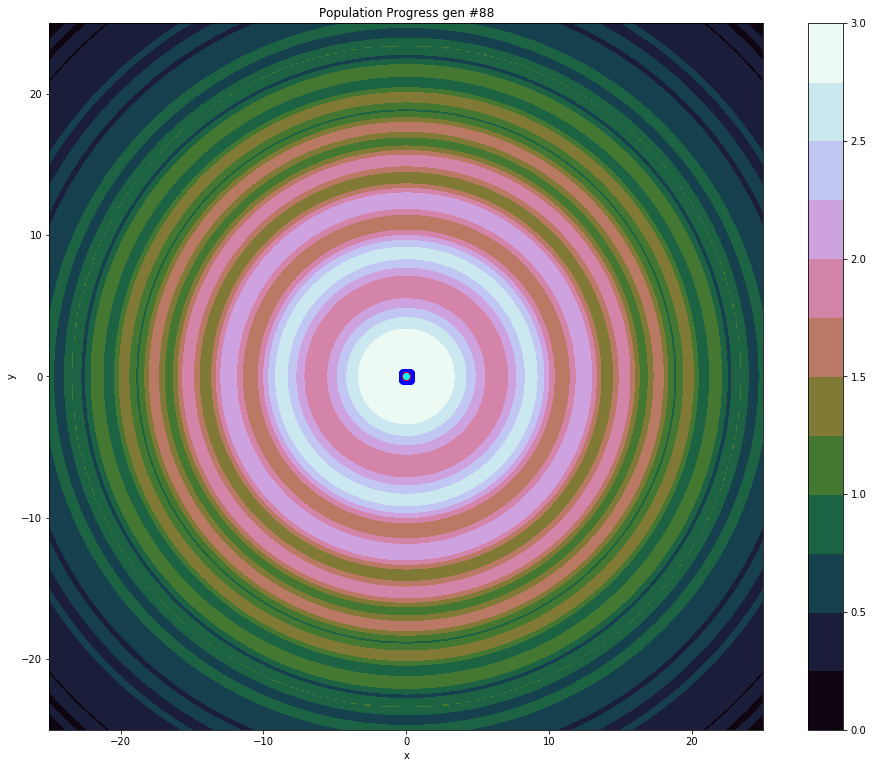

In [0]:
# Plots population on surface at ngen intervals
# Run this cell repeatedly to observe evolution
# cyan: fittest
# red: avg
# a.init_pop()
a.ngen=1
a.evolve()
a.show_weights()
# a.animate()

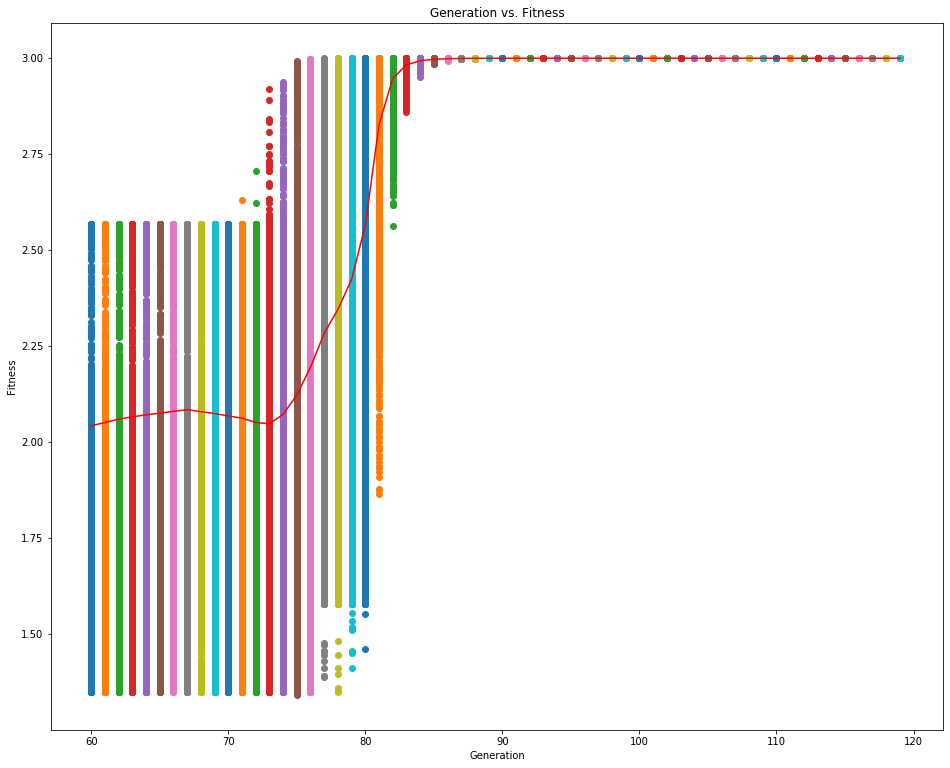

In [0]:
# Alternatively, plot fitness vs time (runs once)
# red: avg
# a.init_pop()
a.ngen=60
a.evolve(plot_fitness=True)